<a href="https://colab.research.google.com/github/raycmarange/AIML431New/blob/main/assign4_task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda
Found file at: /content/SMSSpamCollection.txt
Successfully loaded with tab delimiter
Dataset loaded: 5572 samples
Label distribution:
label
ham     4825
spam     747
Name: count, dtype: int64
Label mapping result:
label
0    4825
1     747
Name: count, dtype: int64
Final dataset size: 5572
Class distribution: {0: 4825, 1: 747}
Training samples: 4457, Testing samples: 1115
Training batches: 279, Testing batches: 70
Starting training...


Epoch 1/3:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch 1/3, Average Loss: 0.0704, LR: 1.33e-05


Epoch 2/3:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch 2/3, Average Loss: 0.0106, LR: 6.67e-06


Epoch 3/3:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch 3/3, Average Loss: 0.0039, LR: 0.00e+00


Evaluating:   0%|          | 0/70 [00:00<?, ?it/s]


EVALUATION RESULTS
Test Accuracy: 0.9910
Weighted F1 Score: 0.9910
Confusion Matrix:
[[962   4]
 [  6 143]]

Classification Report:
               precision    recall  f1-score   support

         ham       0.99      1.00      0.99       966
        spam       0.97      0.96      0.97       149

    accuracy                           0.99      1115
   macro avg       0.98      0.98      0.98      1115
weighted avg       0.99      0.99      0.99      1115



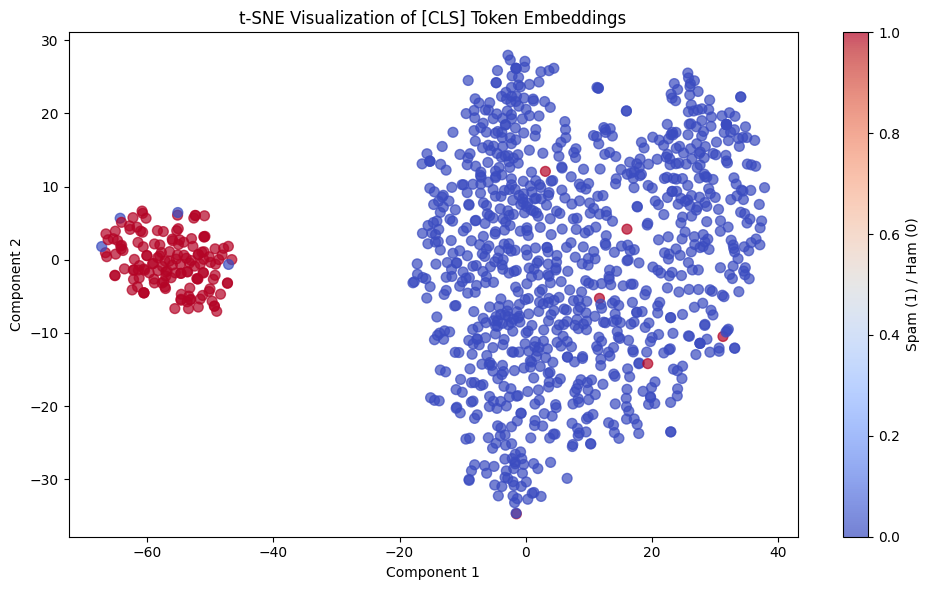

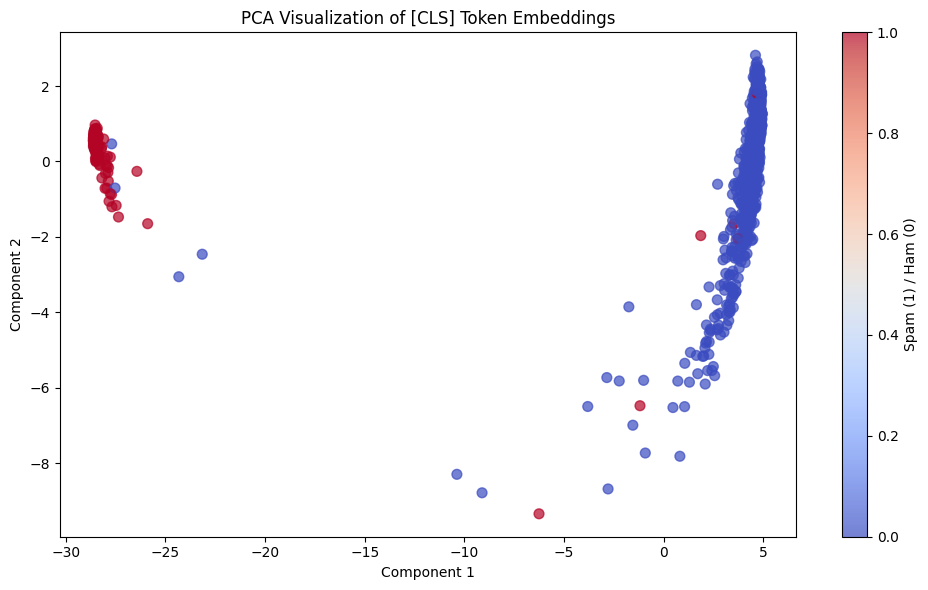

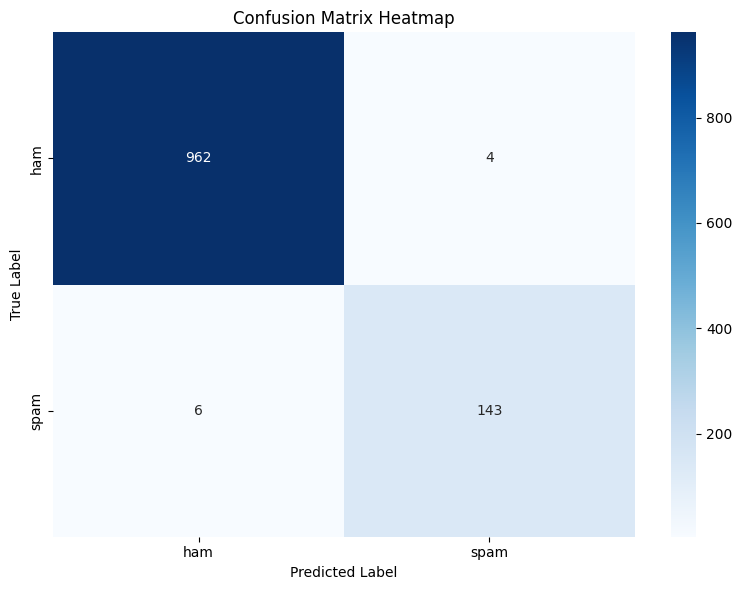

Model saved to bert_spam_classifier.pth
Script execution completed successfully!


In [2]:
#Ray Marange
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='tqdm.auto')
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')
warnings.filterwarnings("ignore", category=SyntaxWarning)

import torch
import pandas as pd
import numpy as np
import os
import re
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
from tqdm.auto import tqdm

class SpamClassifier:
    def __init__(self, model_name='bert-base-uncased', num_labels=2, device=None):
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels,
            output_hidden_states=True
        )
        self.model.to(self.device)
        print(f"Using device: {self.device}")

    def load_and_preprocess_data(self, file_path):
        """Load and preprocess the SMS Spam Collection dataset"""
        try:
            df = pd.read_csv(file_path, delimiter='\t', header=None, names=['label', 'text'], encoding='utf-8')
            print("Successfully loaded with tab delimiter")
        except Exception as e:
            print(f"Error with tab delimiter: {e}")
            try:
                df = pd.read_csv(file_path, delimiter=',', header=None, names=['label', 'text'], encoding='utf-8')
                print("Successfully loaded with comma delimiter")
            except Exception as e2:
                print(f"Error with comma delimiter: {e2}")
                print("Attempting manual file reading...")
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        lines = f.readlines()
                    data = []
                    for line in lines:
                        parts = line.strip().split('\t', 1)
                        if len(parts) == 2:
                            data.append(parts)
                        else:
                            parts = line.strip().split(' ', 1)
                            if len(parts) == 2:
                                data.append(parts)
                    df = pd.DataFrame(data, columns=['label', 'text'])
                    print("Successfully loaded with manual parsing")
                except Exception as e3:
                    print(f"All loading methods failed: {e3}")
                    return None

        if df is None or len(df) == 0:
            print("Failed to load any data")
            return None

        print(f"Dataset loaded: {len(df)} samples")
        print(f"Label distribution:\n{df['label'].value_counts()}")

        df['label'] = df['label'].map({'ham': 0, 'spam': 1})
        print(f"Label mapping result:\n{df['label'].value_counts()}")
        df = df.dropna()
        return df

    def tokenize_data(self, texts, labels, max_length=128):
        """Tokenize text data for BERT"""
        if hasattr(texts, 'tolist'):
            texts = texts.tolist()
        elif hasattr(texts, 'values'):
            texts = texts.values.tolist()

        encoded_data = self.tokenizer(
            texts,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )
        input_ids = encoded_data['input_ids']
        attention_masks = encoded_data['attention_mask']
        labels_tensor = torch.tensor(labels)
        return input_ids, attention_masks, labels_tensor

    def create_dataloaders(self, train_texts, train_labels, test_texts, test_labels, batch_size=16):
        """Create training and testing dataloaders"""
        train_input_ids, train_attention_masks, train_labels_tensor = self.tokenize_data(train_texts, train_labels)
        test_input_ids, test_attention_masks, test_labels_tensor = self.tokenize_data(test_texts, test_labels)

        train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels_tensor)
        test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels_tensor)

        train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
        test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

        print(f"Training batches: {len(train_dataloader)}, Testing batches: {len(test_dataloader)}")
        return train_dataloader, test_dataloader

    def train(self, train_dataloader, epochs=3, learning_rate=2e-5):
        """Train the model with explicit learning rate scheduling"""
        optimizer = AdamW(self.model.parameters(), lr=learning_rate, eps=1e-8)
        total_steps = len(train_dataloader) * epochs

        # Explicit learning rate scheduler
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )

        print("Starting training...")
        for epoch in range(epochs):
            self.model.train()
            total_loss = 0
            progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs}')

            for batch in progress_bar:
                b_input_ids, b_attention_mask, b_labels = [t.to(self.device) for t in batch]

                self.model.zero_grad()
                outputs = self.model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
                loss = outputs.loss
                total_loss += loss.item()

                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()  # Explicit scheduler step

                # Update progress bar with current learning rate
                current_lr = scheduler.get_last_lr()[0]
                progress_bar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'lr': f'{current_lr:.2e}'
                })

            avg_loss = total_loss / len(train_dataloader)
            current_lr = scheduler.get_last_lr()[0]
            print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}, LR: {current_lr:.2e}")

    def evaluate(self, test_dataloader):
        """Evaluate the model performance"""
        self.model.eval()
        predictions, true_labels, cls_embeddings = [], [], []

        for batch in tqdm(test_dataloader, desc='Evaluating'):
            b_input_ids, b_attention_mask, b_labels = [t.to(self.device) for t in batch]

            with torch.no_grad():
                outputs = self.model(b_input_ids, attention_mask=b_attention_mask)

            logits = outputs.logits
            if outputs.hidden_states is not None:
                cls_embedding = outputs.hidden_states[-1][:, 0, :].cpu().numpy()
                cls_embeddings.extend(cls_embedding)

            preds = torch.argmax(logits, dim=1).flatten().cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(b_labels.cpu().numpy())

        return predictions, true_labels, np.array(cls_embeddings) if cls_embeddings else None

    @staticmethod
    def print_evaluation_metrics(true_labels, predictions):
        """Print comprehensive evaluation metrics"""
        accuracy = accuracy_score(true_labels, predictions)
        f1 = f1_score(true_labels, predictions, average='weighted') if len(np.unique(true_labels)) > 1 else 1.0 if accuracy == 1.0 else 0.0
        conf_matrix = confusion_matrix(true_labels, predictions, labels=sorted(set(true_labels + predictions)))
        target_names = ['ham', 'spam']
        present_target_names = [target_names[i] for i in np.unique(true_labels + predictions) if i < len(target_names)]

        print("\n" + "="*50)
        print("EVALUATION RESULTS")
        print("="*50)
        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"Weighted F1 Score: {f1:.4f}")
        print(f"Confusion Matrix:\n{conf_matrix}")
        print("\nClassification Report:\n",
              classification_report(true_labels, predictions,
                                  labels=np.unique(true_labels + predictions),
                                  target_names=present_target_names, zero_division=0))

        return accuracy, f1, conf_matrix

    @staticmethod
    def visualize_results(cls_embeddings, true_labels, predictions, conf_matrix):
        """Create visualization plots"""
        # TSNE and PCA visualizations
        if cls_embeddings is not None and len(cls_embeddings) >= 2:
            methods = [('t-SNE', TSNE(n_components=2, random_state=42, perplexity=min(30, len(cls_embeddings)-1))),
                      ('PCA', PCA(n_components=2, random_state=42))]

            for method_name, reducer in methods:
                if len(cls_embeddings) > 1:
                    embeddings_2d = reducer.fit_transform(cls_embeddings)

                    plt.figure(figsize=(10, 6))
                    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                                        c=true_labels, cmap='coolwarm', alpha=0.7, s=50)
                    plt.colorbar(scatter, label='Spam (1) / Ham (0)')
                    plt.title(f'{method_name} Visualization of [CLS] Token Embeddings')
                    plt.xlabel('Component 1')
                    plt.ylabel('Component 2')
                    plt.tight_layout()
                    plt.show()

        # Confusion matrix heatmap
        if conf_matrix.size > 1:
            target_names = ['ham', 'spam']
            present_indices = np.unique(np.concatenate([np.unique(true_labels), np.unique(predictions)]))
            present_target_names = [target_names[i] for i in present_indices if i < len(target_names)]

            plt.figure(figsize=(8, 6))
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                       xticklabels=present_target_names, yticklabels=present_target_names)
            plt.title('Confusion Matrix Heatmap')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.tight_layout()
            plt.show()

    def save_model(self, filepath='bert_spam_classifier.pth'):
        """Save the trained model"""
        torch.save(self.model.state_dict(), filepath)
        print(f"Model saved to {filepath}")

def run_task1_baseline(file_path):
    """
    Runs the full Task 1 pipeline using the refactored SpamClassifier class.
    """
    # Initialize classifier
    classifier = SpamClassifier()

    # --- File path detection and data loading ---
    current_dir = os.getcwd()
    possible_paths = [
        "SMSSpamCollection",
        f"{current_dir}/SMSSpamCollection",
        f"{current_dir}/SMSSpamCollection.txt",
    ]

    file_path = None
    for path in possible_paths:
        if os.path.exists(path):
            file_path = path
            print(f"Found file at: {path}")
            break

    if not file_path:
        print("SMSSpamCollection file not found. Creating a sample dataset.")
        sample_data = {
            'label': ['ham']*10 + ['spam']*10,
            'text': [
                "Hey, let's meet up.", "Can you pick up groceries?", "Great job!",
                "See you tomorrow.", "Don't forget the keys.", "Lunch at 1pm?",
                "Call me later.", "Are you coming?", "What's up?", "I'm on my way."
            ] + [
                "WINNER! Click here to claim your prize.", "URGENT! You've won a new phone.",
                "Free money now!", "Act fast, limited time offer.", "Get your loan approved today.",
                "Congratulations! You've been selected.", "Limited time offer: 50% off!",
                "Your account needs verification.", "Claim your free gift now!",
                "You're eligible for a special discount."
            ]
        }
        df = pd.DataFrame(sample_data)
        df['label'] = df['label'].map({'ham': 0, 'spam': 1})
    else:
        df = classifier.load_and_preprocess_data(file_path)

    if df is None or len(df) == 0:
        print("Data loading failed, skipping further processing.")
        return

    print(f"Final dataset size: {len(df)}")
    print(f"Class distribution: {df['label'].value_counts().to_dict()}")

    # Split data
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        df['text'].values, df['label'].values, test_size=0.2, random_state=42, stratify=df['label']
    )
    print(f"Training samples: {len(train_texts)}, Testing samples: {len(test_texts)}")

    # Create dataloaders
    train_dataloader, test_dataloader = classifier.create_dataloaders(
        train_texts, train_labels, test_texts, test_labels
    )

    # Train the model
    classifier.train(train_dataloader, epochs=3)

    # Evaluate the model
    predictions, true_labels, cls_embeddings = classifier.evaluate(test_dataloader)
    accuracy, f1, conf_matrix = classifier.print_evaluation_metrics(true_labels, predictions)

    # Visualize results - FIXED: Now passing predictions parameter
    classifier.visualize_results(cls_embeddings, true_labels, predictions, conf_matrix)

    # Save model
    classifier.save_model()

    print("Script execution completed successfully!")

# Run the main function
if __name__ == "__main__":
    try:
        current_dir = os.getcwd()
        file_name = "SMSSpamCollection.txt"
        file_path = os.path.join(current_dir, file_name)
        run_task1_baseline(file_path)
    except Exception as e:
        print(f"An error occurred: {e}")